In [8]:
import os
import subprocess
import time
from datetime import datetime
from influxdb import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
SERVER_CMD = "audita-worker"
K6_SCRIPT = "k6.js"
INFLUXDB_HOST = "localhost"
INFLUXDB_PORT = 8086
INFLUXDB_DB = 'k6'
SERVER_LOG = "server.log"
INFLUXDB_URL = f'http://{INFLUXDB_HOST}:{INFLUXDB_PORT}/{INFLUXDB_DB}'

In [42]:
configurations = [
    {'workers': 1, 'dispatchers': 1, 'batch': 1, 'queue': 200000},
    {'workers': 8, 'dispatchers': 1, 'batch': 1, 'queue': 200000}
]
reports = []

In [43]:
client = InfluxDBClient(
    host=INFLUXDB_HOST,
    port=INFLUXDB_PORT,
    database=INFLUXDB_DB
)

In [44]:
for config in configurations:
    workers = config['workers']
    dispatchers = config['dispatchers']
    batch = config['batch']
    queue = config['queue']

    env = os.environ.copy()
    env['THREADS_WORKERS'] = str(workers)
    env['THREADS_DISPATCHERS'] = str(dispatchers)
    env['BATCH_SIZE'] = str(batch)
    env['QUEUE_SIZE'] = str(queue)

    with open(SERVER_LOG, 'a') as log:
        server_process = subprocess.Popen(
            SERVER_CMD,
            env=env,
            stdout=log,
            stderr=subprocess.STDOUT,
            shell=True,
            text=True
        )

    time.sleep(3)

    start_time = datetime.now()

    try:
        subprocess.run([
            'k6', 'run', K6_SCRIPT,
            '--out', f'influxdb={INFLUXDB_URL}',
            '--tag', f'config=Workers:{workers}_Dispatchers:{dispatchers}_Batch:{batch}'
        ], check=True)

    finally:
        end_time = datetime.now()
        server_process.terminate()
        server_process.wait()
        time.sleep(1)

    reports.append((start_time, end_time, config))


         /\      Grafana   /‾‾/  
    /\  /  \     |\  __   /  /   
   /  \/    \    | |/ /  /   ‾‾\ 
  /          \   |   (  |  (‾)  |
 / __________ \  |_|\_\  \_____/ 

     execution: local
        script: k6.js
        output: InfluxDBv1 (http://localhost:8086)

     scenarios: (100.00%) 1 scenario, 10 max VUs, 1m30s max duration (incl. graceful stop):
              * default: 10 looping VUs for 1m0s (gracefulStop: 30s)


running (0m01.0s), 10/10 VUs, 4653 complete and 0 interrupted iterations
default   [   2% ] 10 VUs  0m01.0s/1m0s

running (0m02.0s), 10/10 VUs, 9036 complete and 0 interrupted iterations
default   [   3% ] 10 VUs  0m02.0s/1m0s

running (0m03.0s), 10/10 VUs, 13743 complete and 0 interrupted iterations
default   [   5% ] 10 VUs  0m03.0s/1m0s

running (0m04.0s), 10/10 VUs, 19461 complete and 0 interrupted iterations
default   [   7% ] 10 VUs  0m04.0s/1m0s

running (0m05.0s), 10/10 VUs, 24761 complete and 0 interrupted iterations
default   [   8% ] 10 VUs  0m05.0s/1m

In [45]:
reports

[(datetime.datetime(2025, 3, 5, 22, 19, 13, 760105),
  datetime.datetime(2025, 3, 5, 22, 20, 14, 454051),
  {'workers': 1, 'dispatchers': 1, 'batch': 1, 'queue': 200000}),
 (datetime.datetime(2025, 3, 5, 22, 20, 25, 771167),
  datetime.datetime(2025, 3, 5, 22, 21, 26, 282918),
  {'workers': 8, 'dispatchers': 1, 'batch': 1, 'queue': 200000})]

In [46]:
def http_reqs_grouped_by_time(start_time, end_time):
    start_rfc = start_time.astimezone().isoformat('T', 'seconds')
    end_rfc = end_time.astimezone().isoformat('T', 'seconds')

    query = f"""
    SELECT
        sum(value)
    FROM http_reqs
    WHERE time > '{start_rfc}'
        AND time < '{end_rfc}'
    GROUP BY time(1s)
    """

    try:
        result = client.query(query)
        return result.get_points()

    except Exception as e:
        print(f"❌ Erro na consulta: {str(e)}")

def http_req_duration_grouped_by_time(start_time, end_time):
    start_rfc = start_time.astimezone().isoformat('T', 'seconds')
    end_rfc = end_time.astimezone().isoformat('T', 'seconds')

    query = f"""
    SELECT
        mean(value)
    FROM http_req_duration
    WHERE time > '{start_rfc}'
        AND time < '{end_rfc}'
    GROUP BY time(1s)
    """

    try:
        result = client.query(query)
        return result.get_points()

    except Exception as e:
        print(f"❌ Erro na consulta: {str(e)}")

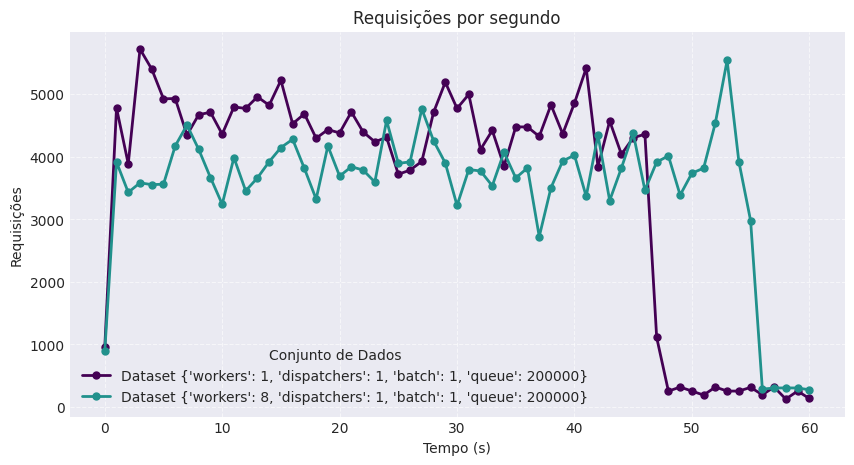

In [47]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 5))

for i, report in enumerate(sorted(reports)):
    http_reqs = http_reqs_grouped_by_time(report[0], report[1])
    df = pd.DataFrame(http_reqs)

    color = plt.cm.viridis(i / len(reports))

    plt.plot(df.index, df['sum'],
             marker="o", linestyle="-", linewidth=2, markersize=5,
             label=f"Dataset {report[2]}", color=color)

plt.xlabel("Tempo (s)", fontsize=10)
plt.ylabel("Requisições", fontsize=10)
plt.title("Requisições por segundo", fontsize=12)
plt.legend(title="Conjunto de Dados", fontsize=10)
plt.grid(linestyle="--", alpha=0.6)
plt.show()


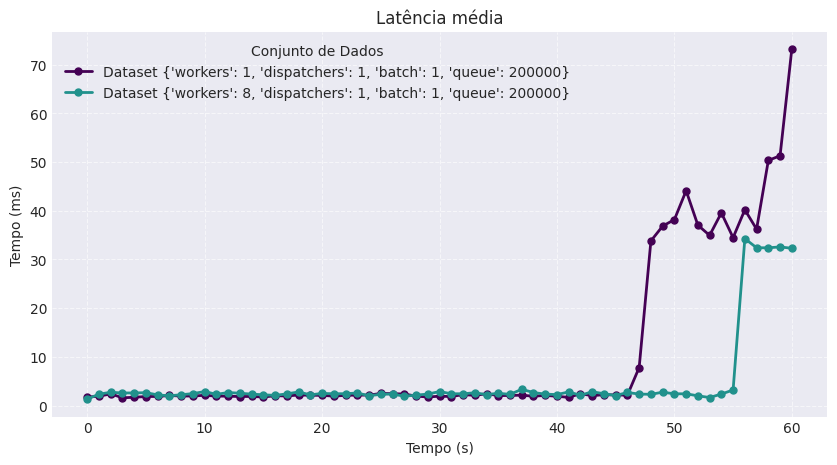

In [48]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 5))

for i, report in enumerate(sorted(reports)):
    http_req_duration = http_req_duration_grouped_by_time(report[0], report[1])
    df = pd.DataFrame(http_req_duration)

    color = plt.cm.viridis(i / len(reports))

    plt.plot(df.index, df['mean'],
             marker="o", linestyle="-", linewidth=2, markersize=5,
             label=f"Dataset {report[2]}", color=color)

plt.xlabel("Tempo (s)", fontsize=10)
plt.ylabel("Tempo (ms)", fontsize=10)
plt.title("Latência média", fontsize=12)
plt.legend(title="Conjunto de Dados", fontsize=10)
plt.grid(linestyle="--", alpha=0.6)

plt.show()